# Deep Pensieve™
A Residual Multi-Stage Maximum Mean Discrepancy Variational Resize-Convolution Auto-Encoder with Group Normalization and Structural Similarity Loss

## Imports

In [ ]:
import time
import json
import random
import numpy as np
import tensorflow as tf

from libs import utils, gif
from libs.group_norm import GroupNormalization

from keras.models import Model, load_model, model_from_json
from keras.layers import Input, Flatten, Reshape, Add, Activation, Lambda
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.callbacks import LambdaCallback

from keras import optimizers
from keras import backend as K

from keras_contrib.losses import DSSIMObjective

## Load Images

In [ ]:
DIRECTORY = 'roadtrip'

SIZE = 256
CHANNELS = 3
FEATURES = SIZE*SIZE*CHANNELS

MODEL_NAME = DIRECTORY+'-'+str(SIZE)

In [ ]:
# load images
imgs, xs, ys = utils.load_images(directory="imgs/"+DIRECTORY,rx=SIZE,ry=SIZE)

# normalize pixels
IMGS = imgs/127.5 - 1
FLAT = np.reshape(IMGS,(-1,FEATURES))
SAMPLES =  np.random.permutation(FLAT)[:9]
TOTAL_BATCH = IMGS.shape[0]

# print shapes
print("MODEL: ",MODEL_NAME)
print("IMGS: ",IMGS.shape)
print("FLAT: ",FLAT.shape)
print("SAMPLES: ",SAMPLES.shape)

## Group Normalization

https://medium.com/syncedreview/facebook-ai-proposes-group-normalization-alternative-to-batch-normalization-fb0699bffae7

The mainstream normalization technique for almost all convolutional neural networks today is Batch Normalization (BN), which has been widely adopted in the development of deep learning. Proposed by Google in 2015, BN can not only accelerate a model’s converging speed, but also alleviate problems such as Gradient Dispersion in the deep neural network, making it easier to train models.

Dr. Wu and Dr. He however argue in their paper Group Normalization that normalizing with batch size has limitations, as BN cannot ensure the model accuracy rate when the batch size becomes smaller. As a result, researchers today are normalizing with large batches, which is very memory intensive, and are avoiding using limited memory to explore higher-capacity models.

Dr. Wu and Dr. He believe their new GN technique is a simple but effective alternative to BN. Specifically, GN divides channels — also referred to as feature maps that look like 3D chunks of data — into groups and normalizes the features within each group. GN only exploits the layer dimensions, and its computation is independent of batch sizes.

The paper reports that GN had a 10.6% lower error rate than its BN counterpart for ResNet-50 in ImageNet with a batch size of 2 samples; and matched BN performance while outperforming other normalization techniques with a regular batch size.

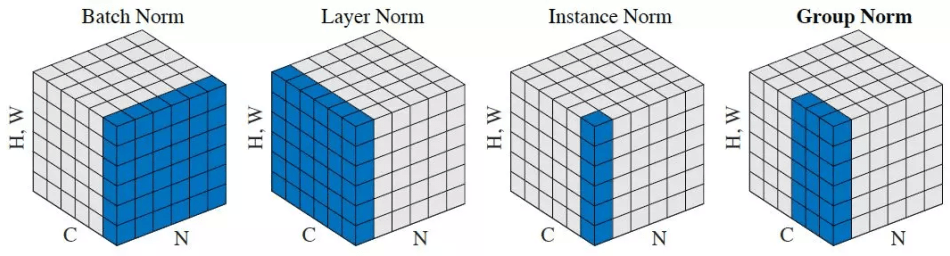

## Encoder

In [ ]:
def encode(x):
    # set current layer
    current_layer = Reshape((SIZE,SIZE,CHANNELS))(x)
    
    # convolution layers
    for layer, n_filters in enumerate(FILTERS):

        # stacked 3x3 convolutions with group normalization + activation
        current_layer = Conv2D(n_filters,3,padding='SAME',kernel_initializer=INITIALIZER)(current_layer)
        current_layer = GroupNormalization(groups=n_filters,axis=-1)(current_layer)
        current_layer = Activation(ACTIVATION)(current_layer)

        current_layer = Conv2D(n_filters,3,padding='SAME',kernel_initializer=INITIALIZER)(current_layer)
        current_layer = GroupNormalization(groups=n_filters,axis=-1)(current_layer)
        current_layer = Activation(ACTIVATION)(current_layer)
         
        # max pooling
        current_layer = MaxPooling2D()(current_layer)
    
    # grab the last shape for reconstruction
    shape = current_layer.get_shape().as_list()
    
    # flatten
    flat = Flatten()(current_layer)
    
    # latent vector
    z = Dense(LATENT_DIM,name='encoder')(flat)
    
    return z, (shape[1],shape[2],shape[3])

## Maximum Mean Discrepancy 

https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/

Maximum mean discrepancy (MMD, (Gretton et al. 2007)) is based on the idea that two distributions are identical if and only if all their moments are the same. Therefore, we can define a divergence by measuring how “different” the moments of two distributions p(z) and q(z) are. MMD can accomplish this efficiently via the kernel embedding trick:

A kernel can be intuitively interpreted as a function that measures the “similarity” of two samples. It has a large value when two samples are similar, and small when they are different. For example, the Gaussian kernel considers points that are close in Euclidean space to be “similar”. A rough intuition of MMD, then, is that if two distributions are identical, then the average “similarity” between samples from each distribution, should be identical to the average “similarity” between mixed samples from both distributions.

In [ ]:
def compute_kernel(x, y):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
    tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
    return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)

In [ ]:
def vae_loss(y_true,y_pred):
    epsilon = tf.random_normal(tf.stack([BATCH_SIZE, LATENT_DIM]))
    latent_loss = compute_mmd(epsilon, y_pred)
    return latent_loss

## Deconvolution and Checkerboard Artifacts 

https://distill.pub/2016/deconv-checkerboard/

When we have neural networks generate images, we often have them build them up from low resolution, high-level descriptions. This allows the network to describe the rough image and then fill in the details.

In order to do this, we need some way to go from a lower resolution image to a higher one. We generally do this with the deconvolution operation. Roughly, deconvolution layers allow the model to use every point in the small image to “paint” a square in the larger one.

Unfortunately, deconvolution can easily have “uneven overlap,” putting more of the metaphorical paint in some places than others. In particular, deconvolution has uneven overlap when the kernel size (the output window size) is not divisible by the stride (the spacing between points on the top). While the network could, in principle, carefully learn weights to avoid this  — as we’ll discuss in more detail later — in practice neural networks struggle to avoid it completely.

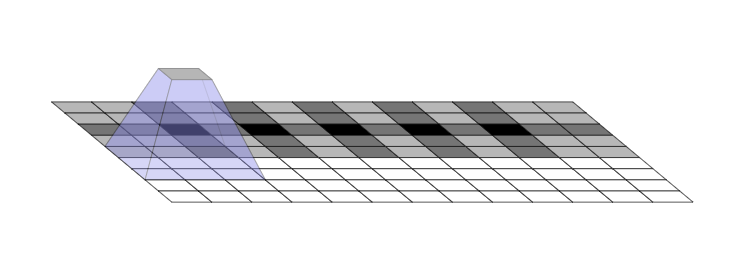

To avoid these artifacts, we’d like an alternative to regular deconvolution (“transposed convolution”). Unlike deconvolution, this approach to upsampling shouldn’t have artifacts as its default behavior. Ideally, it would go further, and be biased against such artifacts.

One approach is to separate out upsampling to a higher resolution from convolution to compute features. For example, you might resize the image (using nearest-neighbor interpolation or bilinear interpolation) and then do a convolutional layer. This seems like a natural approach, and roughly similar methods have worked well in image super-resolution.

Our experience has been that nearest-neighbor resize followed by a convolution works very well, in a wide variety of contexts.

## Decoder

In [ ]:
def decode(z,z_g,shape=None):
    
    # reverse the encoder
    filters = FILTERS[::-1]

    # inflate
    inflated = shape[0]*shape[1]*shape[2]
    inflate = Dense(inflated,name='generator')
    current_layer = inflate(z) ; generator = inflate(z_g)
    
    # reshape
    reshape = Reshape(shape)
    current_layer = reshape(current_layer) ; generator = reshape(generator)
    
    # build layers
    for layer, n_filters in enumerate(filters):
        
        # upsample
        u = UpSampling2D()
        current_layer = u(current_layer) ; generator = u(generator)

        # stacked 3x3 convolutions with group normalization + activation
        c1 = Conv2D(n_filters,3,padding='SAME',kernel_initializer=INITIALIZER)
        b1 = GroupNormalization(groups=n_filters,axis=-1)
        a1 = Activation(ACTIVATION)

        current_layer = c1(current_layer) ; generator = c1(generator)
        current_layer = b1(current_layer) ; generator = b1(generator)
        current_layer = a1(current_layer) ; generator = a1(generator)

        c2 = Conv2D(n_filters,3,padding='SAME',kernel_initializer=INITIALIZER)
        b2 = GroupNormalization(groups=n_filters,axis=-1)
        a2 = Activation(ACTIVATION)

        current_layer = c2(current_layer) ; generator = c2(generator)
        current_layer = b2(current_layer) ; generator = b2(generator)
        current_layer = a2(current_layer) ; generator = a2(generator)
    
    # output convolution + activation
    conv = Conv2D(CHANNELS,1,padding='SAME')
    activation = Activation('tanh',name='decoder_dssim')
    
    current_layer = conv(current_layer)       ; generator = conv(generator)
    current_layer = activation(current_layer) ; generator = activation(generator)
    
    flatten = Flatten(name='decoder')
    decoder_loss = flatten(current_layer)
    
    return current_layer, generator, decoder_loss

## Enhanced Deep Residual Networks for Single Image Super-Resolution

https://arxiv.org/abs/1707.02921

Recently, residual networks exhibit excellent performance in computer vision problems from the lowlevel to high-level tasks. Although Ledig et al. successfully applied the ResNet architecture to the super-resolution problem with SRResNet, we further improve the performance by employing better ResNet structure.

We remove the batch normalization layers from our network as Nah et al.[19] presented in their image deblurring work. Since batch normalization layers normalize the features, they get rid of range flexibility from networks by normalizing the features, it is better to remove them. We experimentally show that this simple modification increases the performance substantially as detailed in

Furthermore, GPU memory usage is also sufficiently reduced since the batch normalization layers consume the same amount of memory as the preceding convolutional layers. Our baseline model without batch normalization layer saves approximately 40% of memory usage during training, compared to SRResNet. Consequently, we can build up a larger model that has better performance than conventional ResNet structure under limited computational resources.

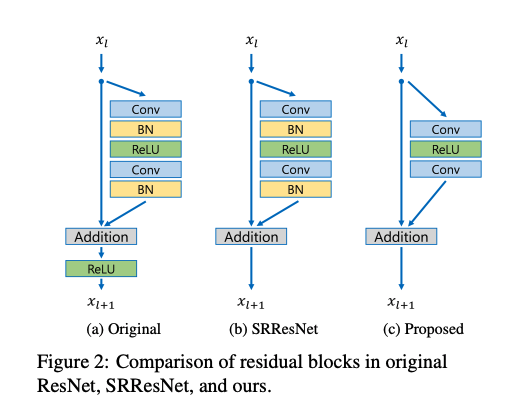

## Residual

In [ ]:
def residual(x,x_g):
    
    current_layer = x ; generator = x_g

    # shortcuts
    shortcut = current_layer 
    shortcut_g = generator

    # conv 1
    c1 = Conv2D(R_FILTERS,3,padding='SAME',kernel_initializer=INITIALIZER)
    current_layer = c1(current_layer) ; generator = c1(generator)
    
    # activation 1
    a1 = Activation(ACTIVATION)
    current_layer = a1(current_layer) ; generator = a1(generator)

    # conv 2
    c2 = Conv2D(R_FILTERS,3,padding='SAME',kernel_initializer=INITIALIZER)
    current_layer = c2(current_layer) ; generator = c2(generator)

    # residual scaling
    scale = Lambda(lambda x: x * R_SCALING)
    current_layer = scale(current_layer) ; generator = scale(generator)

    # fix shortcut shape if mismatch
    if(shortcut.shape[-1] != current_layer.shape[-1]):
        s = Conv2D(R_FILTERS,1,padding='SAME',kernel_initializer=INITIALIZER)
        shortcut = s(current_layer) ; shortcut_g = s(generator)
        
    # merge shortcut
    merge = Add()
    current_layer = merge([current_layer, shortcut]) ; generator = merge([generator, shortcut_g])

    return current_layer, generator

## Multi-Stage Variational Auto-Encoders for Coarse-to-Fine Image Generation 

https://arxiv.org/abs/1705.07202


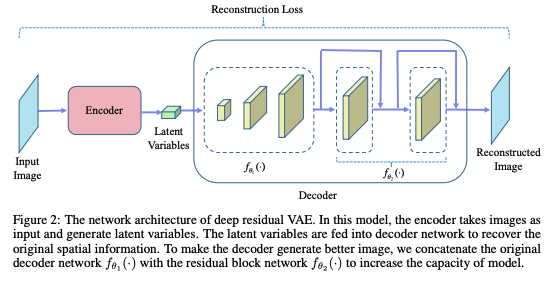

Variational auto-encoder (VAE) is a powerful unsupervised learning framework for image generation. One drawback of VAE is that it generates blurry images due to its Gaussianity assumption and thus L2 loss. To allow the generation of high quality images by VAE, we increase the capacity of decoder network by employing residual blocks and skip connections, which also enable efficient optimization. To overcome the limitation of L2 loss, we propose to generate images in a multi-stage manner from coarse to fine. In the simplest case, the proposed multi-stage VAE divides the decoder into two components in which the second component generates refined images based on the course images generated by the first component. Since the second component is independent of the VAE model, it can employ other loss functions beyond the L2 loss and different model architectures. The proposed framework can be easily generalized to contain more than two components. Experiment results on the MNIST and CelebA datasets demonstrate that the proposed multi-stage VAE can generate sharper images as compared to those from the original VAE.

## Refiner

In [ ]:
def refine(x,x_g):
    
    # reshape
    reshape = Reshape((SIZE,SIZE,CHANNELS))
    current_layer = reshape(x) ; generator = reshape(x_g)

    # residual layers
    for layer in range(R_LAYERS):
    
        # residual block
        current_layer, generator = residual(current_layer,generator)
    
    # output convolution + activation
    conv = Conv2D(CHANNELS,1,padding='SAME')
    activation = Activation('tanh',name='refiner_dssim')
    
    current_layer = conv(current_layer)       ; generator = conv(generator)
    current_layer = activation(current_layer) ; generator = activation(generator)
    
    flatten = Flatten(name='refiner')
    refiner_loss = flatten(current_layer)
    
    return current_layer, generator, refiner_loss

## Callbacks

In [ ]:
RECONS = []

def gifit(epoch=None):
    if (epoch % GIF_STEPS == 0):
        print('saving gif ...')
        z,y,yc,i,ic = AUTOENCODER.predict_on_batch(SAMPLES)
        img = np.clip(127.5*(i+1).reshape((-1, SIZE, SIZE, CHANNELS)), 0, 255)
        RECONS.append(utils.montage(img).astype(np.uint8))
        
def saveit(epoch=None):
    if (epoch == 0):
        print('saving model ...')
        with open(MODEL_NAME+'-autoencoder-model.json', "w") as json_file:
            json_file.write(AUTOENCODER.to_json())
        AUTOENCODER.save(MODEL_NAME+'-autoencoder-model.h5')
        
        print('saving encoder ...')          
        with open(MODEL_NAME+'-encoder-model.json', "w") as json_file:
            json_file.write(ENCODER.to_json())
        ENCODER.save(MODEL_NAME+'-encoder-model.h5')
        
        print('saving generator ...')
        with open(MODEL_NAME+'-generator-model.json', "w") as json_file:
            json_file.write(GENERATOR.to_json())
        GENERATOR.save(MODEL_NAME+'-generator-model.h5')
    
    elif (epoch % MODEL_STEPS == 0):
        print('saving autoencoder ...')
        AUTOENCODER.save_weights(MODEL_NAME+'-autoencoder-weights.h5')
        AUTOENCODER.save(MODEL_NAME+'-autoencoder-model.h5')
        
        print('saving encoder ...')
        ENCODER.save_weights(MODEL_NAME+'-encoder-weights.h5')
        ENCODER.save(MODEL_NAME+'-encoder-model.h5')
        
        print('saving generator ...')
        GENERATOR.save_weights(MODEL_NAME+'-generator-weights.h5')
        GENERATOR.save(MODEL_NAME+'-generator-model.h5')
        
# callbacks
giffer = LambdaCallback(on_epoch_end=lambda epoch, logs: gifit(epoch))
saver = LambdaCallback(on_epoch_end=lambda epoch, logs: saveit(epoch))

## Learning to Generate Images with Perceptual Similarity Metrics

https://arxiv.org/abs/1511.06409

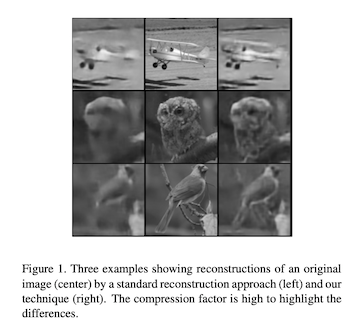

In this paper, we explore loss functions that, unlike MSE, MAE, and likelihoods, are grounded in human perceptual judgments. We show that these perceptual losses lead to representations are superior to other methods, both with respect to reconstructing given images (Figure 1), and generating novel ones. This superiority is demonstrated both in quantitative studies and human judgements. Beyond achieving perceptually superior synthesized images, we also show that that our perceptually-optimized representations are better suited for image classification. Finally, we demonstrate that perceptual losses yield a convincing win when applied to a state-of-the-art architecture for single image super-resolution.


## Model

In [ ]:
# 512px
# FILTERS = [64,80,96,112,96,80,64]

# 256px
FILTERS = [64,96,128,160,128,64]

#128px
#FILTERS = [64,128,196,128,64]

# 64px
#FILTERS = [32,48,64,48]

# Residuals
R_LAYERS  = 24
R_FILTERS = 64
R_SCALING = 0.1

# Default initializer and activation
INITIALIZER = 'he_normal'
ACTIVATION  = 'elu'

# Latent dimension size
LATENT_DIM = 1024

In [ ]:
# input
X = Input(shape=(FEATURES,),name='input')

# latent
Z, shape = encode(X)

# generator input
Z_G = Input(shape=(LATENT_DIM,))

# coarse reconstruction
Y, YG, Y_F = decode(Z,Z_G,shape)

# fine reconstruction
IMG, IMG_G, IMG_F = refine(Y,YG)
    
# define autoencoder
AUTOENCODER = Model(inputs=[X], outputs=[Z,Y,Y_F,IMG,IMG_F])

# define encoder
#ENCODER = Model(inputs=[X], outputs=[Z])
ENCODER = Model(inputs=[AUTOENCODER.input], outputs=[AUTOENCODER.get_layer("encoder").output])

# define generator
GENERATOR = Model(inputs=[Z_G], outputs=[IMG_G])

# define optimizer
ADAM = optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=True)

# define losses
losses = {'encoder':vae_loss,
          'decoder':'mse','decoder_dssim':DSSIMObjective(),
          'refiner':'mae','refiner_dssim':DSSIMObjective() }

# compile models
AUTOENCODER.compile(optimizer=ADAM,loss=losses)
ENCODER.compile(optimizer=ADAM,loss='mse')
GENERATOR.compile(optimizer=ADAM,loss='mse')

# print summary
AUTOENCODER.summary()

## Training

In [ ]:
EPOCHS      = 12501
BATCH_SIZE  = 4

MODEL_STEPS = 10
GIF_STEPS   = 100

SAMPLES =  np.random.permutation(FLAT)[:9]

In [ ]:
# fit model
AUTOENCODER.fit(x=FLAT,y=[FLAT,IMGS,FLAT,IMGS,FLAT],batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=[giffer,saver])

# save animated gif
gif.build_gif(RECONS, saveto=MODEL_NAME+'-final'+ "-"+str(time.time())+'.gif')

print("done")

## Load Models

In [ ]:
print('loading encoder ...')
#ENCODER = load_model(MODEL_NAME+'-encoder.hdf5')

print('loading generator ...')
#GENERATOR = load_model(MODEL_NAME+'-generator.hdf5')

print('done')

## Reconstruction 

In [ ]:
ENC = ENCODER
GEN = GENERATOR

def reconstruct(index=0):
    x = np.reshape(FLAT[index],(-1,FEATURES))
    z = ENC.predict_on_batch(x) ; print(z)
    img = np.reshape(GEN.predict_on_batch(z),(-1,FEATURES))
    
    ref = IMGS[index]/2 + .5
    img = np.reshape(img/2 + .5,(SIZE,SIZE,CHANNELS))
    
    print("PSNR: %.3f" % (utils.psnr(ref,img)))
    print("MS-SSIM: %.3f" % (utils.MultiScaleSSIM(np.reshape(ref,(1,SIZE,SIZE,CHANNELS)),
                                                  np.reshape(img,(1,SIZE,SIZE,CHANNELS)),
                                                  max_val=1.)))
    
    return ref, img

In [ ]:
r = random.randint(0,TOTAL_BATCH-1) ; print(r)
orig, img_g_z = reconstruct(r)
utils.showImagesHorizontally(images=[orig,img_g_z])

## Latent  Animation

In [ ]:
def random_latents(n_imgs=3,path='linear',steps=30,slices=1,directory='roadtrip'):
    imgs = np.random.permutation(FLAT)[:n_imgs]
    latent_animation(imgs,steps,slices,path=path)

def latent_animation(imgs=None,steps=None,slices=None,path=None,filename="latent-animation-"):
    # get encodings
    print('getting latent vectors ...')
    latents = []
    for index,img in enumerate(imgs):
        img = np.reshape(img,(-1,FEATURES))
        latent = ENC.predict_on_batch(img)
        latents.append(latent)

    # calculate latent transitions
    print('calculating latent manifold path ...')
    recons = []
    current_step = None
    for i in range(len(latents)-1):
        print("IMG: " + str(i))
        l1 = latents[i]
        l2 = latents[i+1]

        # latent image distance
        image_distance = l2 - l1

        # sine wave for animation steps
        integral = steps*(1+np.cos(np.pi/steps))/np.pi
        normalizer = image_distance/integral

        # start image
        current_step = l1
    
        recons.append(l1)
        for i in range(steps):
            current_step = l1 + i*image_distance/steps
            recons.append(current_step)
            
            if(i > 1 and (i+1) % int(steps/slices) == 0):
                print('reconstructing ... ',i)
                recons = np.reshape(recons,(-1,LATENT_DIM))
                i = GEN.predict_on_batch(recons)

                # de-normalize and clip the output
                final = np.clip((127.5*(i+1)).reshape((-1,SIZE,SIZE,CHANNELS)),0,255)

                # build the gif
                filename = filename+str(time.time())
                gif.build_gif([utils.montage([r]).astype(np.uint8) for r in final], saveto=filename+"-final.gif",dpi=128)

                print(filename)
                
                recons = []
                filename="latent-animation-"
        recons.append(l2)

In [ ]:
random_latents(n_imgs=5,steps=100,slices=1)

In [ ]:
imgs =  np.random.permutation(FLAT)
for i in range(TOTAL_BATCH):
    print(i)
    latent_animation([imgs[i],imgs[i+1]],40)
    

## Load Model & Continue Training 

In [ ]:
import keras

giffer = LambdaCallback(on_epoch_end=lambda epoch, logs: gifit(epoch))
saver = LambdaCallback(on_epoch_end=lambda epoch, logs: saveit(epoch))

print('loading model ...')
AUTOENCODER = load_model(MODEL_NAME+'-autoencoder-model.h5',
                         custom_objects={'vae_loss': vae_loss, 
                                         'R_SCALING':0.1, 
                                         'DSSIMObjective':DSSIMObjective()})

# define encoder
ENCODER = Model(inputs=[AUTOENCODER.input], outputs=[AUTOENCODER.get_layer("encoder").output])

# define generator
Z = Input(shape=(LATENT_DIM,))
GENERATOR = Model(inputs=[Z], outputs=[AUTOENCODER.get_layer("generator")(Z)])

ENCODER.compile(optimizer=ADAM,loss='mse')
GENERATOR.compile(optimizer=ADAM,loss='mse')

print('resuming training ...')
AUTOENCODER.fit(x=FLAT,y=[FLAT,IMGS,FLAT,IMGS,FLAT],batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=[giffer,saver])

In [ ]:
# from keras.models import model_from_json
# print('loading encoder ...')
# enc_json_file = open(MODEL_NAME+'-encoder-model.json', 'r')
# enc_model_json = enc_json_file.read()
# enc_json_file.close()
# print('loading weights ...')
# enc_loaded_model = model_from_json(enc_model_json)
# enc_loaded_model.load_weights(MODEL_NAME+'-encoder-weights.h5')

# print('loading generator ...')
# gen_json_file = open(MODEL_NAME+'-generator-model.json', 'r')
# gen_model_json = gen_json_file.read()
# gen_json_file.close()
# print('loading weights ...')
# gen_loaded_model = model_from_json(gen_model_json)
# gen_loaded_model.load_weights(MODEL_NAME+'-generator-weights.h5')